# Classify Brain MRI Images (Multi-Class Classification)

## Pre-requisites
Install [kagglehub](https://pypi.org/project/kagglehub/)

## 1 Load Dataset
### 1.1 Download Data and Generate Annotation Files

In [1]:
import kagglehub
import os
from glob import glob
import pandas as pd

# Download dataset and locate it in machine
data_dirname = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
# print(data_dirname)
train_dirname = os.path.join(data_dirname, 'Training')
test_dirname = os.path.join(data_dirname, 'Testing')
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get training files
tr_gl_files = glob(os.path.join(train_dirname, classes[0], '*.jpg'))
tr_me_files = glob(os.path.join(train_dirname, classes[1], '*.jpg'))
tr_no_files = glob(os.path.join(train_dirname, classes[2], '*.jpg'))
tr_pi_files = glob(os.path.join(train_dirname, classes[3], '*.jpg'))
# print(len(tr_gl_files), len(tr_me_files), len(tr_no_files), len(tr_pi_files))
train_files = tr_gl_files + tr_me_files + tr_no_files + tr_pi_files
train_labels = [classes[0]] * len(tr_gl_files) + \
    [classes[1]] * len(tr_me_files) + \
    [classes[2]] * len(tr_no_files) + \
    [classes[-1]] * len(tr_pi_files)
train_dict = {'path': train_files, 'label': train_labels}
df_train = pd.DataFrame(train_dict)
# print(df_train)
df_train.to_csv('annotation_train.csv', header=False, index=False)

# Get testing files
te_gl_files = glob(os.path.join(test_dirname, classes[0], '*.jpg'))
te_me_files = glob(os.path.join(test_dirname, classes[1], '*.jpg'))
te_no_files = glob(os.path.join(test_dirname, classes[2], '*.jpg'))
te_pi_files = glob(os.path.join(test_dirname, classes[3], '*.jpg'))
# print(len(te_gl_files), len(te_me_files), len(te_no_files), len(te_pi_files))
test_files = te_gl_files + te_me_files + te_no_files + te_pi_files
test_labels = [classes[0]] * len(te_gl_files) + \
    [classes[1]] * len(te_me_files) + \
    [classes[2]] * len(te_no_files) + \
    [classes[-1]] * len(te_pi_files)
test_dict = {'path': test_files, 'label': test_labels}
df_test = pd.DataFrame(test_dict)
# print(df_train)
df_test.to_csv('annotation_test.csv', header=False, index=False)


/home/pbd0/miniforge3/envs/3321/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Create PyTorch Dataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2 as cv

class TumorDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.imgs_info.iloc[idx, 0]
        img_raw = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        image = cv.resize(img_raw, (128, 128))
        if self.imgs_info.iloc[idx, 1] == classes[0]:
            category = 0
        elif self.imgs_info.iloc[idx, 1] == classes[1]:
            category = 1
        elif self.imgs_info.iloc[idx, 1] == classes[2]:
            category = 2
        else:
            category = 3
        sample = {'image': image, 'category': category}
        return sample
    
dataset_train = TumorDataset(annotations_file='annotation_train.csv')
# for i, sample in enumerate(dataset_train):
#     image = sample['image']
#     label = sample['category']
#     if not i%100:  # i % 100 != 0
#         print(i, image.shape, label)
# print(i, image.shape, label)
dataset_test = TumorDataset(annotations_file='annotation_test.csv')

dataloader_train = DataLoader(dataset_train, batch_size=10000, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=10000, shuffle=True)



### 1.3 Pre-Process the Data

In [3]:
import numpy as np
# Extract features and labels from the dataloaders
data_train = next(iter(dataloader_train))
data_test = next(iter(dataloader_test))

# Separate features and labels
raw_features_train = data_train['image'].numpy()
raw_features_test = data_test['image'].numpy()
raw_labels_train = data_train['category'].numpy()
raw_labels_test = data_test['category'].numpy()
print(raw_features_train.shape, raw_labels_train.shape)
print(raw_features_test.shape, raw_labels_test.shape)

# Reshape
reshaped_features_train = raw_features_train.reshape(raw_features_train.shape[0], -1)
reshaped_features_test = raw_features_test.reshape(raw_features_test.shape[0], -1)
onehot_labels_train = np.zeros((raw_labels_train.shape[0], len(classes)))
onehot_labels_test = np.zeros((raw_labels_test.shape[0], len(classes)))
print(reshaped_features_train.shape, onehot_labels_train.shape)
print(reshaped_features_test.shape, onehot_labels_test.shape)

# One-hot encoding
onehot_labels_train[np.arange(raw_labels_train.shape[0]), raw_labels_train] = 1
onehot_labels_test[np.arange(raw_labels_test.shape[0]), raw_labels_test] = 1
print(raw_labels_train[:4])
print(onehot_labels_train[:4])

# Rescale
rescaled_features_train = reshaped_features_train / 255
rescaled_features_test = reshaped_features_test / 255
# print(rescaled_features_test[0, 8000:8500])

features_train = rescaled_features_train
features_test = rescaled_features_test
labels_train = onehot_labels_train
labels_test = onehot_labels_test


(5712, 128, 128) (5712,)
(1311, 128, 128) (1311,)
(5712, 16384) (5712, 4)
(1311, 16384) (1311, 4)
[3 3 1 0]
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


## 2 Build Multi-Layer Perceptron Model

In [4]:
import numpy as np
def init_params(layer_sizes):
    """
    layer_sizes: list/tuple
    """
    parameters = {}
    for i in range(len(layer_sizes)-1):
        parameters['W' + str(i+1)] = np.random.normal(0, 0.0001, size=(layer_sizes[i+1], layer_sizes[i]))
        parameters['b' + str(i+1)] = np.random.normal(0, 0.0001, size=(1, layer_sizes[i+1]))
    return parameters

# Sanity check
dummy_layer_sizes = list(range(1, 10))
dummy_params = init_params(dummy_layer_sizes)
print(len(dummy_params))

def linear(in_features, weight, bias):
    return in_features @ weight.T + bias

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(out_features):
    probs = np.exp(out_features) / np.sum(np.exp(out_features), axis=1, keepdims=True)
    return probs

def forward(features_input, params):
    num_layers = int(len(params) / 2 - 1)
    cache = {'X0': features_input}
    for i in range(num_layers):
        cache['Z' + str(i+1)] = linear(cache['X' + str(i)], params['W' + str(i+1)], params['b' + str(i+1)])
        cache['X' + str(i+1)] = relu(cache['Z' + str(i+1)])
    cache['Z' + str(i+2)] = linear(cache['X' + str(i+1)], params['W' + str(i+2)], params['b' + str(i+2)])
    predictions = softmax(cache['Z' + str(i+2)])

    return predictions, cache

# Sanity check
dummy_features = np.random.normal(size=(4, 1))
dummy_preds, dummy_cache = forward(dummy_features, dummy_params)
print(dummy_preds)

16
[[0.11110751 0.11109948 0.11110439 0.11110372 0.11112242 0.11111873
  0.11111797 0.11110921 0.11111657]
 [0.11110751 0.11109948 0.11110439 0.11110372 0.11112242 0.11111873
  0.11111797 0.11110921 0.11111657]
 [0.11110751 0.11109948 0.11110439 0.11110372 0.11112242 0.11111873
  0.11111797 0.11110921 0.11111657]
 [0.11110751 0.11109948 0.11110439 0.11110372 0.11112242 0.11111873
  0.11111797 0.11110921 0.11111657]]


## 3 Cross Entropy Loss

In [5]:
def ce_loss(predictions, labels):
    error = -np.sum(labels * np.log(predictions), axis=1)
    return np.mean(error)

# Sanity check
dummy_labels = np.zeros((4, 9))
dummy_labels[np.arange(4), np.random.randint(0, 9, (4,))] = 1
dummy_loss = ce_loss(dummy_preds, dummy_labels)
print(dummy_labels)
print(dummy_loss)

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
2.1972067271091973


## 4 Back-Propagation

In [6]:
def d_relu(x):
    dydx = np.ones_like(x)
    dydx[x < 0] = 0
    return dydx

def grad(predictions, labels, params, cache):
    num_layers = int(len(params) / 2)
    grads = {'dZ' + str(num_layers): predictions - labels}
    for i in reversed(range(num_layers)):
        grads['dW' + str(i+1)] = grads['dZ' + str(i+1)].T @ cache['X' + str(i)]
        grads['db' + str(i+1)] = np.mean(grads['dZ' + str(i+1)], axis=0, keepdims=True)
        if i==0:
            break
        grads['dX' + str(i)] = grads['dZ' + str(i+1)] @ params['W' + str(i+1)]
        grads['dZ' + str(i)] = grads['dX' + str(i)] * d_relu(cache['Z' + str(i)])

    return grads

# Sanity check
dummy_grad = grad(dummy_preds, dummy_labels, dummy_params, dummy_cache)
print(dummy_grad)

{'dZ8': array([[ 0.11110751,  0.11109948,  0.11110439, -0.88889628,  0.11112242,
         0.11111873,  0.11111797,  0.11110921,  0.11111657],
       [ 0.11110751,  0.11109948,  0.11110439,  0.11110372, -0.88887758,
         0.11111873,  0.11111797,  0.11110921,  0.11111657],
       [ 0.11110751,  0.11109948,  0.11110439,  0.11110372,  0.11112242,
        -0.88888127,  0.11111797,  0.11110921,  0.11111657],
       [-0.88889249,  0.11109948,  0.11110439,  0.11110372,  0.11112242,
         0.11111873,  0.11111797,  0.11110921,  0.11111657]]), 'dW8': array([[ 0.00000000e+00, -4.29209633e-05,  0.00000000e+00,
        -2.41975624e-05,  0.00000000e+00,  0.00000000e+00,
        -6.28952121e-06, -6.64021373e-05],
       [ 0.00000000e+00,  3.43322870e-05,  0.00000000e+00,
         1.93555221e-05,  0.00000000e+00,  0.00000000e+00,
         5.03095995e-06,  5.31147733e-05],
       [ 0.00000000e+00,  3.43338022e-05,  0.00000000e+00,
         1.93563764e-05,  0.00000000e+00,  0.00000000e+00,
       

## 5 Gradient Descent Model Update

Iterations 1: training loss: 1.3862940641906007, testing loss: 1.3862985782026833
Iterations 2: training loss: 1.3862937225999665, testing loss: 1.3862982106878292
Iterations 3: training loss: 1.3862933718933386, testing loss: 1.3862978342405077
Iterations 4: training loss: 1.3862930065247927, testing loss: 1.3862974427974473
Iterations 5: training loss: 1.3862926203475752, testing loss: 1.3862970293073162
Iterations 6: training loss: 1.386292208004719, testing loss: 1.3862965880779938
Iterations 7: training loss: 1.3862917637537926, testing loss: 1.386296112907559
Iterations 8: training loss: 1.386291280034981, testing loss: 1.386295594937031
Iterations 9: training loss: 1.386290748755732, testing loss: 1.386295025590598
Iterations 10: training loss: 1.386290161966965, testing loss: 1.3862943962732424
Iterations 11: training loss: 1.3862895110731686, testing loss: 1.3862936973267106
Iterations 12: training loss: 1.3862887861525053, testing loss: 1.3862929183184305
Iterations 13: train

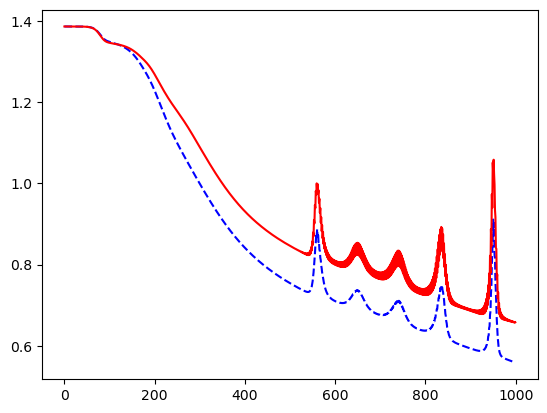

In [7]:
layer_sizes = [features_train.shape[1], 128, 4]  # structure
params = init_params(layer_sizes)
num_iters = 1000
learning_rate = 3e-6  # 0.00001 
losses_train, losses_test = [], []

for i in range(num_iters):
    preds_train, cache = forward(features_train, params)
    preds_test, _ = forward(features_test, params)
    loss_train = ce_loss(preds_train, labels_train)
    loss_test = ce_loss(preds_test, labels_test)
    print(f"Iterations {i+1}: training loss: {loss_train}, testing loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    grads = grad(preds_train, labels_train, params, cache)
    for j in range(len(layer_sizes) - 1):
        params['W' + str(j+1)] = params['W' + str(j+1)] - learning_rate * grads['dW' + str(j+1)]
        params['b' + str(j+1)] = params['b' + str(j+1)] - learning_rate * grads['db' + str(j+1)]

import matplotlib.pyplot as plt
plt.plot(range(num_iters), losses_train, '--b', range(num_iters), losses_test, 'r')




> Took more than 8 minutes to finish 1000 epochs

6 Accuracy Assess

In [8]:
pred_classes_train = np.argmax(preds_train, axis=1)
is_correct_train = pred_classes_train == raw_labels_train
num_correct_train = sum(is_correct_train)
accuracy_train = num_correct_train / len(raw_labels_train)
print(accuracy_train)

0.7815126050420168
